# Importando as bibliotecas necessárias

In [1]:
import wave
from sklearn.decomposition import PCA
import pywt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.io import wavfile
from numpy.fft import fft, fftfreq
from scipy import signal
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Reshape
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv1D,MaxPooling1D,UpSampling1D
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
from scipy import signal
import keras.callbacks
from sklearn.model_selection import StratifiedKFold


Using TensorFlow backend.


# Importando os dados

Importando todos os arquivos .wav que estão na pasta de amostras aleatórias. Resolução de inteiro de 16 bits.

In [3]:
path = "/media/gabriel/OS/Users/gabriel.gomes/Google Drive/Radice - Pós-Graduação/Disciplinas/Trabalho Final - SEL5712 e SEL5742/Arquivos de Dados/Testes 05_07_19/freq/*.wav"
ys = []
fnames = []
y = []
resh = True
for fname in glob.glob(path): #utiliza a biblioteca glob para varrer a pasta na qual os arquivos (loop)
    waveF = []
    fnames.append(fname) 
    #lê p .wav
    fs, data = wavfile.read(fname)
    #limitando o tamanho das amostras, porque está variado
    data = np.array(data[0:150000])
    #dividindo em 10 partes de 15000 amostras, que dá quase um segundo.
    if(resh == True):
        data = np.reshape(data,(300,500))
        for d in data:
            y.append(d)
    else:        
        y.append(data)

fnames = [f.replace('C:\\Users\\gabriel.gomes\\Google Drive\\Radice - Pós-Graduação\Disciplinas\Trabalho Final - \
SEL5712 e SEL5742\\Arquivos de Dados\Amostras Aleatórias\\', '') for f in fnames] #pega o nome dos arquivos
df = pd.DataFrame(np.array(y))

#criando o nome das colunas para o dataframe

n_samples = 600
colunas = []
j = 0
if(resh == True):
    for i in range(n_samples*10):
        if(i%n_samples == 0 and i > 0):
            j += 1 
        colunas.append("Am." + str(int(i/n_samples)+1) + "p." + str(i-j*n_samples))
else:
    for i in range(n_samples):
        colunas.append("Am." + str(i))

df.index = colunas

In [4]:
#definindo os labels das amostras: 0 -> sem defeito; 1 -> com defeito
labels = []
labels[0:4*n_samples] = [1 for i in range(4*n_samples)]
labels[4*n_samples:7*n_samples] = [0 for i in range(4*n_samples,7*n_samples)]
labels[7*n_samples:n_samples*10] = [1 for i in range(7*n_samples,n_samples*10)]
labels = pd.DataFrame(labels)
labels.index = colunas
labels.head()

,0
Am.1p.0,1
Am.1p.1,1
Am.1p.2,1
Am.1p.3,1
Am.1p.4,1


# Análise do espectro de frequência dos sinais
Abordagem 1: Análise da resposta em frequência dos sinais sem defeito e dos sinais com defeito. Pegar a FFT média.

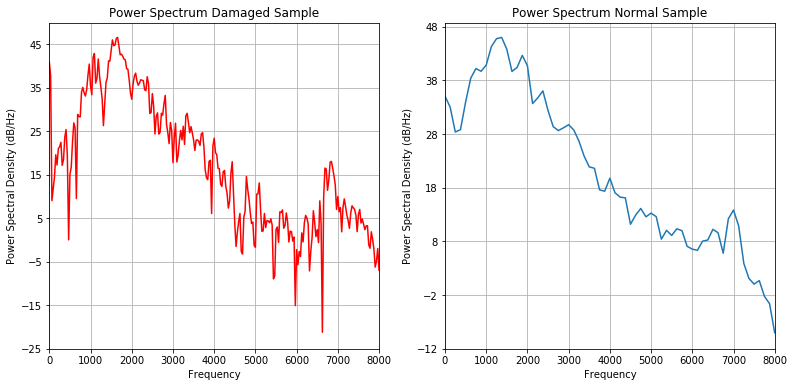

In [8]:
#amostras individuais
plt.figure(figsize=(13, 6))
plt.subplot(1,2,1)
plt.psd(df.iloc[0][:],512,fs, c = 'r')
plt.title("Power Spectrum Damaged Sample")
plt.xlim([0, 8000])
plt.subplot(1,2,2)
plt.psd(df.iloc[10][:],128,fs)
plt.title("Power Spectrum Normal Sample")
plt.xlim([0, 8000])
plt.show()

É possível perceber que o espectro de frequência da amostra defeituosa é diferente do da amostra não defeituosa. Olhando apenas para forma, é possível perceber que os picos secundários são deslocados. Para confirmar que isso se repete sempre, é necessário analisar a média dos espectros de frequência.

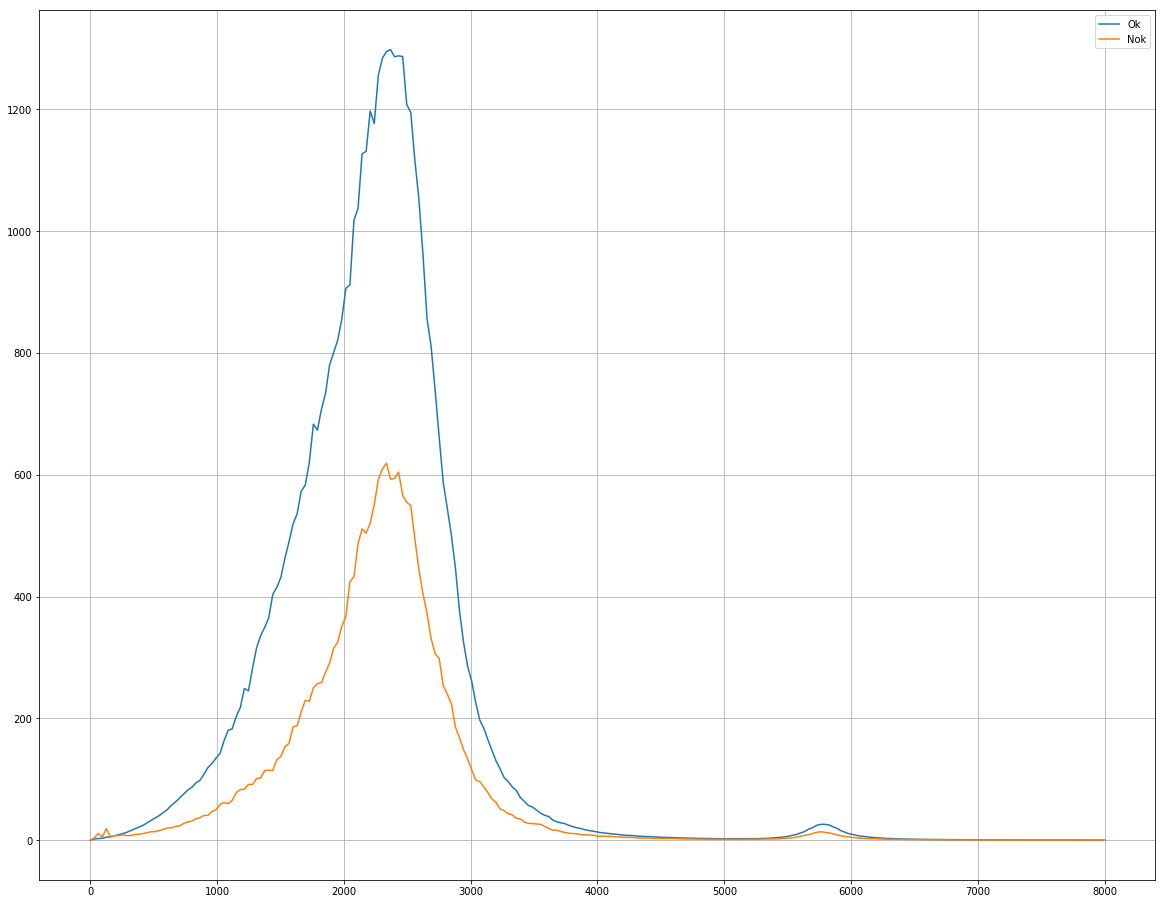

In [9]:
f, Pxx_den = signal.periodogram(df.iloc[0][:], fs)

meanf_ok = Pxx_den - Pxx_den
meanf_nok = Pxx_den - Pxx_den #cria vetor de nulos
count_ok = 0
count_nok = 0
fourier = []
#faz a média dos espectros de frequência com defeito e sem defeito
for i in range(len(labels)):
    f, Pxx_den = signal.periodogram(df.iloc[i][:], fs)
    if(labels.iloc[i][0] == 0):
        meanf_ok += (Pxx_den-min(Pxx_den))/(max(Pxx_den)-min(Pxx_den))
        fourier.append((Pxx_den-min(Pxx_den))/(max(Pxx_den)-min(Pxx_den)))
        count_ok += 1
    else:
        fourier.append((Pxx_den-min(Pxx_den))/(max(Pxx_den)-min(Pxx_den)))
        meanf_nok += (Pxx_den-min(Pxx_den))/(max(Pxx_den)-min(Pxx_den))
        count_nok += 1
#amostras individuais
# plt.figure(figsize=(13, 6))
# plt.subplot(1,2,1)
# plt.semilogy(f,meanf_nok, c = 'r')
# plt.grid()
# plt.title("Power Spectrum Damaged Sample")
# plt.xlabel("Frequency [Hz]")
# plt.xlim([0, 8000])
# plt.ylim([1e-3, 1e2])
# plt.subplot(1,2,2)
# plt.semilogy(f,meanf_ok)
# plt.title("Power Spectrum Normal Sample")
# plt.xlim([0, 8000])
# #plt.ylim([1e-3, 1e2])
# plt.xlabel("Frequency [Hz]")
# plt.grid()
# plt.show()
plt.figure(figsize = (20,16))
plt.plot(f,meanf_nok)
plt.plot(f,meanf_ok)
plt.legend(["Ok", "Nok"])
plt.grid()
plt.show()

É possível perceber que a média dos espectros de frequência é próximo. Todavia, os valores são diferente.
A correlação entre os espectros de frequência é mostrada abaixo:

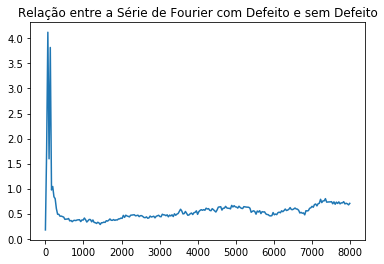

In [10]:
plt.title("Relação entre a Série de Fourier com Defeito e sem Defeito")
plt.plot(f,meanf_ok/meanf_nok)
plt.show()

In [11]:
#convertendo a série de fourier para dataframe
fourier = pd.DataFrame(fourier)

Como o resultado é próximo de uma linha, tudo indica que o espectro de frequência por si só não pode ser utilizado como entrada para classificação. Assim sendo, utilizaremos transformada wavelet para termos noção temporal e de frequência, uma vez que a frequência por si só pode não ser suficiente.

# Wavelet analysis

Considerando que a frequência de amostragem é 16 kHz, a primeira frequência rastreável é 8kHz.
Assim sendo:

* Coef. Detalhe Nv.1 = 4kHz ~ 8kHz
* Coef. Detalhe Nv.2 = 2kHz ~ 4kHz 
* Coef. Detalhe Nv.3 = 1kHz ~ 2kHz 
* Coef. Detalhe Nv.4 = 500Hz ~ 1kHz 

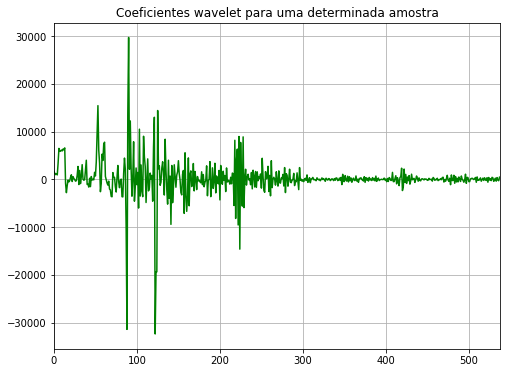

In [13]:
df_dwt = []
df_dwt = pd.DataFrame(np.zeros((df.shape[0],538))) #vetor auxiliar para receber os coeficientes
df_dwt.index = colunas #adicionando o nome das colunas

for i in range(len(df)):    
    #decomposição wavelet até o nível 4
    coeffs = pywt.wavedecn(df.iloc[i], wavelet='db4', level=6)
    #transformando os coeficientes em um único vetor
    arr, coeff_slices, coeff_shapes = pywt.ravel_coeffs(coeffs)
    df_dwt.iloc[i] = arr #adicionando os coeficientes no vetor de dados

plt.figure(figsize = (8,6))
plt.plot(df_dwt.iloc[0], c = 'g')
plt.title("Coeficientes wavelet para uma determinada amostra")
plt.grid()
plt.xlim([0, len(df_dwt.iloc[0])])
plt.show()


É interessante notar que a maior parte da energia do sinal ficou compreendida entre as amostras 2000 e 6000, que representam o segundo nível de decomposição, ou seja, entre 2~4 kHz

# Tratando os dados
Normalizando os dados e dividindo entre amostras de treinamento e amostras de teste.

In [63]:
#df_wvn = data_frame wavelet normalizado
data = []
from sklearn.model_selection import train_test_split
data = fourier
#data = df_dwt
#data = df
normalizer = MinMaxScaler()
#tem que transpor pq a biblioteca do sklearn normaliza por feature
normalizer.fit(np.array(data).T)
data_n = normalizer.transform(np.array(data).T)
#transpõe de novo para voltar para a forma original
data_n = pd.DataFrame(data_n.T)
data_n.index = colunas


#dividindo em teste e treinamento. 20% das amostras para teste. random_state = 13 para manter sempre o mesmo
#padrão de teste e treinamento.
train_X,test_X,train_Y,test_Y = train_test_split(data_n,
                                                             labels, 
                                                             test_size=0.2)

#data = signal.resample(data,1000,axis = 1)
data_n = np.expand_dims(np.array(data_n),axis= 2) 
print(data_n.shape)

(6000, 251, 1)


In [64]:
data_n.shape[1]

251

In [62]:
#subamostrando o sinal, pq o trem é grande pacas.

#X_train = signal.resample(train_X, 1000,axis = 1)
#X_test = signal.resample(test_X, 1000,axis = 1)
#data = signal.resample(data,1000,axis = 1)
#data = np.expand_dims(np.array(data),axis= 2) 

# Convolutional Neural Network


In [12]:
# batch_size = 10
# epocas = 150

# test_x = np.expand_dims(np.array(X_test),axis= 2)
# callbacks_list = [
#     keras.callbacks.ModelCheckpoint(
#         filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
#         monitor='val_loss', save_best_only=True),
#     keras.callbacks.EarlyStopping(monitor='val_loss',  verbose=1,patience = 200)
# ]
# convolutional_NN_train = convolutional_NN.fit(x_train, train_Y, batch_size=batch_size,
#                                               epochs=epocas,verbose=1,validation_data=(test_x, test_Y),
#                                              callbacks=callbacks_list)

## K-fold Cross Validation
### Arquitetura 1 -> Filtro 1 60 hz de comprimento e filtro 2 

In [65]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

In [75]:
cvscores = []
labels = np.array(labels)
for train, test in kfold.split(data_n, labels):
  # create model
    convolutional_NN = Sequential()
    convolutional_NN.add(Dense(80, activation='relu',))
    convolutional_NN.add(Dense(20, activation='relu'))
    convolutional_NN.add(Dropout(rate = 0.5)) #0.35
    convolutional_NN.add(Dense(10, activation='relu'))
    convolutional_NN.add(Dense(5, activation='relu',))
    convolutional_NN.add(Dropout(rate = 0.5)) #0.35
    convolutional_NN.add(Flatten())
    convolutional_NN.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    convolutional_NN.compile(loss='mean_squared_error', optimizer = Adam(),metrics=['accuracy'])
    
    # Fit the model
    convolutional_NN.fit(data_n[train], labels[train], epochs=100, batch_size=20, verbose=0)
    
    # evaluate the model
    scores = convolutional_NN.evaluate(data_n[test], labels[test], verbose=0)
    print("%s: %.2f%%" % (convolutional_NN.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

acc: 76.00%


KeyboardInterrupt: 

In [46]:
data_n.shape

(6000, 251, 1)

In [50]:

cvscores = []
labels = np.array(labels)
for train, test in kfold.split(data_n, labels):
  # create model
    convolutional_NN = Sequential()
    convolutional_NN.add(Dense(80, activation='relu',input_shape=(data_n.shape[1],1)))
    convolutional_NN.add(Conv1D(70,kernel_size = 134, activation = 'relu'))
    convolutional_NN.add(Dense(40, activation='relu'))
    convolutional_NN.add(MaxPooling1D((2)))
    convolutional_NN.add(Conv1D(30,kernel_size = 40, activation = 'relu'))
    convolutional_NN.add(MaxPooling1D((2)))
    convolutional_NN.add(Dense(40, activation='relu'))
    convolutional_NN.add(Dense(20, activation='relu'))
    convolutional_NN.add(Dropout(rate = 0.25)) #0.35
    convolutional_NN.add(Flatten())
    convolutional_NN.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    convolutional_NN.compile(loss='mean_squared_error', optimizer = Adam(),metrics=['accuracy'])
    
    # Fit the model
    convolutional_NN.fit(data_n[train], labels[train], epochs=100, batch_size=20, verbose=0)
    
    # evaluate the model
    scores = convolutional_NN.evaluate(data[test], labels[test], verbose=0)
    print("%s: %.2f%%" % (convolutional_NN.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

W0722 15:08:15.780757 139907896153920 deprecation_wrapper.py:119] From /home/gabriel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



KeyboardInterrupt: 

## Arquitetura 2, Adição de mais uma camada convolucional

In [ ]:
cvscores = []
labels = np.array(labels)
for train, test in kfold.split(data, labels):
  # create model
    convolutional_NN = Sequential()
    convolutional_NN.add(Dense(100, activation='relu',input_shape=(data_n.shape[1],1)))
    convolutional_NN.add(Conv1D(100,kernel_size = 15, activation = 'relu')) #kernel_size = 10
    convolutional_NN.add(MaxPooling1D((2)))
    convolutional_NN.add(Conv1D(80,kernel_size = 10, activation = 'relu')) #kernel_size = 5;
    convolutional_NN.add(Dense(80, activation='relu'))
    convolutional_NN.add(Dropout(rate = 0.615))
    convolutional_NN.add(Flatten())
    convolutional_NN.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    convolutional_NN.compile(loss='mean_squared_error', optimizer = Adam(),metrics=['accuracy'])
    
    # Fit the model
    convolutional_NN.fit(data[train], labels[train], epochs=100, batch_size=20, verbose=0)
    
    # evaluate the model
    scores = convolutional_NN.evaluate(data_n[test], labels[test], verbose=0)
    print("%s: %.2f%%" % (convolutional_NN.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

In [ ]:
cvscores = []
labels = np.array(labels)
for train, test in kfold.split(data, labels):
  # create model
    convolutional_NN = Sequential()
    convolutional_NN.add(Dense(100, activation='relu',input_shape=(data_n.shape[1],1)))
    convolutional_NN.add(Conv1D(100,kernel_size = 15, activation = 'relu')) #kernel_size = 10
    convolutional_NN.add(MaxPooling1D((2)))
    convolutional_NN.add(Conv1D(80,kernel_size = 5, activation = 'relu')) #kernel_size = 5;
    convolutional_NN.add(Dense(80, activation='relu'))
    convolutional_NN.add(Dropout(rate = 0.61))
    convolutional_NN.add(Flatten())
    convolutional_NN.add(Dense(1, activation='sigmoid'))
    
    
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    convolutional_NN.compile(loss='mean_squared_error', optimizer = Adam(),metrics=['accuracy'])
    
    # Fit the model
    convolutional_NN.fit(data_n[train], labels[train], epochs=100, batch_size=20, verbose=0)
    
    # evaluate the model
    scores = convolutional_NN.evaluate(data[test], labels[test], verbose=0)
    print("%s: %.2f%%" % (convolutional_NN.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

W0722 16:07:05.762311 139907896153920 nn_ops.py:4224] Large dropout rate: 0.61 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [ ]:
cvscores = []
labels = np.array(labels)
for train, test in kfold.split(data, labels):
  # create model
    convolutional_NN = Sequential()
    convolutional_NN.add(Dense(1000, activation='relu',input_shape=(data_n.shape[1],1)))
    convolutional_NN.add(Conv1D(150,kernel_size = 30, activation = 'relu')) #kernel_size = 10
    convolutional_NN.add(MaxPooling1D((2)))
    convolutional_NN.add(Dense(300, activation='relu'))
    convolutional_NN.add(Conv1D(100,kernel_size = 10, activation = 'relu')) #kernel_size = 5;
    convolutional_NN.add(Dense(150, activation='relu'))
    convolutional_NN.add(Conv1D(50,kernel_size = 5, activation = 'relu')) #kernel_size = 5;
    convolutional_NN.add(Dense(30, activation='relu'))
    convolutional_NN.add(Dense(20, activation='relu'))
    convolutional_NN.add(Dense(10, activation='relu'))
    convolutional_NN.add(Dropout(rate = 0.6))
    convolutional_NN.add(Flatten())
    convolutional_NN.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    convolutional_NN.compile(loss='mean_squared_error', optimizer = Adam(),metrics=['accuracy'])
    
    # Fit the model
    convolutional_NN.fit(data[train], labels[train], epochs=100, batch_size=20, verbose=0)
    
    # evaluate the model
    scores = convolutional_NN.evaluate(data[test], labels[test], verbose=0)
    print("%s: %.2f%%" % (convolutional_NN.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

W0719 21:38:20.061650 140174138545984 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


acc: 82.50%


# KNN

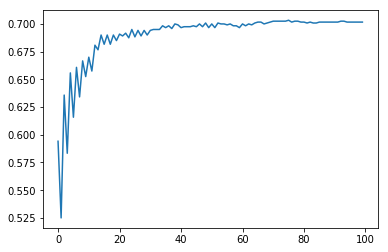

In [43]:
from sklearn.neighbors import KNeighborsClassifier
score = []
for i in range(100):
    neigh = KNeighborsClassifier(n_neighbors=i+1)
    a = neigh.fit(train_X, np.ravel(train_Y)) 
    score.append(a.score(test_X,np.ravel(test_Y)))
plt.plot(score)

In [44]:
max(score)

0.7033333333333334

# Matriz de confusão

In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(labels, y_pred.argmax(axis=1))

# Autoencoder


Autoenconders are a type of neural network that can learn how to represent an input into a lower dimensional space without losing much information. It traces the relation between the real input and this lower dimensional input through the neural network weights and activation functions. The main idea behing autoenconder is: reduce the dimensionality of the data (also called encoder part) after it try to reconstruct your data using the code created (so called decoder part). A good autoenconder is the one in which the difference between the real input and the reconstructed input is small.

There are several types of autoencoders. Convolutional autoencoders are good choices when you don't know what pattern you are looking for, considering they can extract features using the idea of filters. The input is represented into a code passing it through filters which covolve (the reason of the name convolutional) with it and produce a new codified input. Each filter is responsible for extracting one feature

In [ ]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Reshape
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [14]:
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv1D,MaxPooling1D,UpSampling1D
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical

def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv1D(32, 10, activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv1D(32, 10, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling1D(pool_size=(2))(conv1) #14 x 14 x 32
    conv2 = Conv1D(64, 10, activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv1D(64, 10, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling1D(pool_size=(2))(conv2) #7 x 7 x 64
    conv3 = Conv1D(128, 10, activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv1D(128, 10, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv1D(256, 10, activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv1D(256, 10, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv1D(128, 10, activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv1D(128, 10, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv1D(64, 10, activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv1D(64, 10, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling1D(2)(conv6) #14 x 14 x 64
    conv7 = Conv1D(32, 10, activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv1D(32, 10, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling1D((2))(conv7) # 28 x 28 x 32
    decoded = Conv1D(1, 10, activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

x_train = np.array(X_train)
#expandindo as dimensões para a primeira camada
x_train = np.expand_dims(X_train,axis= 2)

In [18]:
input_img = Input(shape = (15000, 1))
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=5)
]
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 15000, 1)          0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 15000, 32)         352       
_________________________________________________________________
batch_normalization_29 (Batc (None, 15000, 32)         128       
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 15000, 32)         10272     
_________________________________________________________________
batch_normalization_30 (Batc (None, 15000, 32)         128       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 7500, 32)          0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 7500, 64)          20544     
__________

In [19]:
autoencoder_train = autoencoder.fit(x_train, x_train, batch_size=2,epochs=100,verbose=1, callbacks=callbacks_list,validation_data=(x_train, x_train))


Train on 20 samples, validate on 20 samples
Epoch 1/100
20/20 [==============================] - 58s 3s/step - loss: 0.0148 - val_loss: 0.0328


/home/gabriel/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `acc` which is not available. Available metrics are: val_loss,loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/100
20/20 [==============================] - 11s 547ms/step - loss: 0.0026 - val_loss: 0.0127
Epoch 3/100
20/20 [==============================] - 11s 565ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 4/100
20/20 [==============================] - 12s 583ms/step - loss: 0.0027 - val_loss: 0.0088
Epoch 5/100
20/20 [==============================] - 11s 560ms/step - loss: 0.0026 - val_loss: 0.0121
Epoch 6/100
20/20 [==============================] - 12s 577ms/step - loss: 0.0018 - val_loss: 0.0609
Epoch 7/100
20/20 [==============================] - 13s 642ms/step - loss: 0.0020 - val_loss: 0.0258
Epoch 8/100
20/20 [==============================] - 12s 616ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 9/100
20/20 [==============================] - 12s 603ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 10/100
20/20 [==============================] - 13s 646ms/step - loss: 0.0020 - val_loss: 0.0679
Epoch 11/100
20/20 [==============================] - 12s 605ms/step - loss: 0.00

In [362]:
#quantidade de dados que entra por vez na rede neural
batch_size = 1
#número de épocas
epochs = 50
#número de atributos
n_features = train_X.shape[1]
#especifica que o modelo é sequencial
model_m = Sequential()

#primeira camada convolucional, 10 filtros com tamanho 100. Features grandes.
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(n_features, 1)))

#segunda camada convolucional, 100 features com tamanho 10. Features médias.
model_m.add(Conv1D(100, 10, activation='relu'))

#terceira camada convolucional, 1000 filtros com tamanho 5. Features pequenas.
model_m.add(Conv1D(100, 10, activation='relu'))

model_m.add(MaxPooling1D(2))
model_m.add(Conv1D(160, 5, activation='relu'))
model_m.add(Dense(50, activation='sigmoid'))
model_m.add(GlobalAveragePooling1D())
#model_m.add(Dropout(0))
model_m.add(Dense(1, activation='sigmoid'))
print(model_m.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_133 (Conv1D)          (None, 149927, 10)        1010      
_________________________________________________________________
conv1d_134 (Conv1D)          (None, 149918, 100)       10100     
_________________________________________________________________
conv1d_135 (Conv1D)          (None, 149909, 100)       100100    
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 74954, 100)        0         
_________________________________________________________________
conv1d_136 (Conv1D)          (None, 74950, 160)        80160     
_________________________________________________________________
dense_38 (Dense)             (None, 74950, 50)         8050      
_________________________________________________________________
global_average_pooling1d_30  (None, 50)                0         
__________

In [367]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=5)
]

model_m.compile(loss='binary_crossentropy',
                optimizer='RMSprop', metrics=['accuracy'])

In [368]:
BATCH_SIZE = 4
EPOCHS = 50
x_train = np.array(train_X)
y_train = np.array(train_Y)
#expandindo as dimensões para a primeira camada
x_train = np.expand_dims(train_X,axis= 2)
#y_train = np.expand_dims(train_Y,axis= 2)

history = model_m.fit(x_train,
                       y_train,
                       batch_size=BATCH_SIZE,
                       epochs=EPOCHS,
                       callbacks=callbacks_list,
                       validation_split=0.2,
                       verbose=1)

Train on 16 samples, validate on 4 samples
Epoch 1/50
16/16 [==============================] - 21s 1s/step - loss: 0.6997 - acc: 0.6875 - val_loss: 0.5874 - val_acc: 0.7500
Epoch 2/50
16/16 [==============================] - 21s 1s/step - loss: 0.6529 - acc: 0.6875 - val_loss: 0.5708 - val_acc: 0.7500
Epoch 3/50
16/16 [==============================] - 21s 1s/step - loss: 0.6467 - acc: 0.6875 - val_loss: 0.5718 - val_acc: 0.7500
Epoch 4/50
16/16 [==============================] - 21s 1s/step - loss: 0.6475 - acc: 0.6875 - val_loss: 0.5798 - val_acc: 0.7500
Epoch 5/50
16/16 [==============================] - 21s 1s/step - loss: 0.6609 - acc: 0.6875 - val_loss: 0.5772 - val_acc: 0.7500
Epoch 6/50
16/16 [==============================] - 21s 1s/step - loss: 0.6230 - acc: 0.6875 - val_loss: 0.5770 - val_acc: 0.7500


In [267]:
#prevendo os resultados
x_test = np.array(test_X)
y_test = np.array(test_Y)
x_test = np.expand_dims(test_X,axis= 2)

In [268]:
model_m.predict(x_test,y_test)

/home/gabriel/anaconda3/lib/python3.7/site-packages/keras/engine/training_utils.py:369: RuntimeWarning: divide by zero encountered in floor_divide
  num_batches = (size + batch_size - 1) // batch_size  # round up


TypeError: only integer scalar arrays can be converted to a scalar index

# PCA

In [227]:
pca = PCA(n_components = 2, whiten = True).fit(dfw)
print(sum(pca.explained_variance_ratio_))
X_pca = pca.transform(dfw)
#print(pca.components_)
PC1, PC2 = pca.components_
#print(pca.explained_variance_ratio_)
#print(sum(pca.explained_variance_ratio_))
X_pca = pd.DataFrame(X_pca)
X_pca.columns = ['PC1', 'PC2']

0.5974338995594077


# K-means

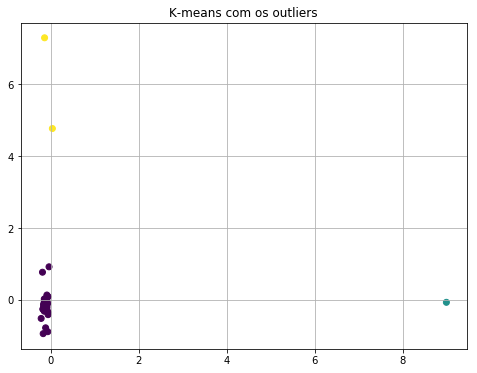

In [228]:
model = KMeans(n_clusters = 3)
model = model.fit(X_pca)#scale(X_pca))
plt.figure(figsize = (8, 6))
plt.grid()
plt.scatter(X_pca['PC1'], X_pca['PC2'], c = model.labels_.astype(np.float))
plt.title("K-means com os outliers")
plt.show()

In [229]:
print(model.labels_)
j = 0
for i in model.labels_:
    if(i == 2):
        print(j)
    j = j+1

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 2 0 0 0 0]
29
78


# K-means sem os outliers

In [230]:
X_pca = X_pca.drop(X_pca.index[[0,29,78]])
fnames = pd.DataFrame(fnames)
fnames = fnames.drop(fnames.index[[0,29,78]])

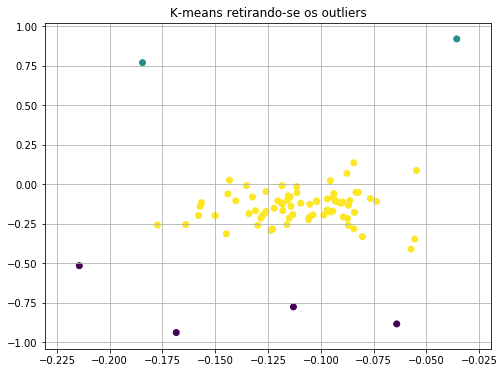

In [231]:
model = KMeans(n_clusters = 3)
model = model.fit(X_pca)#scale(X_pca))
plt.figure(figsize = (8, 6))
plt.scatter(X_pca['PC1'], X_pca['PC2'], c = model.labels_.astype(np.float))
plt.title("K-means retirando-se os outliers")
plt.grid()
plt.show()

In [232]:
fnames = pd.DataFrame(fnames)
fnames = fnames.drop(fnames.index[[0,29,78]])

In [233]:
parametros_modelo = pd.DataFrame(model.labels_)
amostras_clusterizadas = []
for cluster in (range(len(fnames))):
    amostras_clusterizadas.append(str(fnames.iloc[cluster][0]) + "   cluster " + str(parametros_modelo.iloc[cluster][0]))

In [234]:
amostras_clusterizadas

['W203_200516201420.wav   cluster 2',
 'W204_200516211315.wav   cluster 2',
 'W205_200516211512.wav   cluster 1',
 'W206_250516211141.wav   cluster 2',
 'W207_250516211411.wav   cluster 2',
 'W208_300516210305.wav   cluster 2',
 'W209_300516210635.wav   cluster 2',
 'W210_300516210818.wav   cluster 2',
 'W211_300516222233.wav   cluster 2',
 'W212_300516222423.wav   cluster 2',
 'W213_030616174835.wav   cluster 2',
 'W214_030616175127.wav   cluster 2',
 'W215_030616180529.wav   cluster 2',
 'W216_030616180806.wav   cluster 2',
 'W217_090616203521.wav   cluster 2',
 'W218_090616203920.wav   cluster 0',
 'W219_090616204204.wav   cluster 2',
 'W220_090616204407.wav   cluster 2',
 'W221_090616230029.wav   cluster 2',
 'W222_090616230255.wav   cluster 2',
 'W223_130616182010.wav   cluster 2',
 'W224_130616182202.wav   cluster 2',
 'W225_130616182401.wav   cluster 2',
 'W226_130616182603.wav   cluster 2',
 'W227_140616212154.wav   cluster 2',
 'W228_140616212440.wav   cluster 2',
 'W229_14061